In [2]:
!pip install gower

In [3]:
import pandas
import numpy
import gower
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn
import matplotlib.pyplot as plt


my_data_frame = pandas.read_csv('/Credit-Data.csv', header = 0) # Your path may differ
print(my_data_frame)

    status  duration history purpose  amount bonds employment  rate marital  \
0      A11         6     A34     A43    1169   A65        A75     4     A93   
1      A12        48     A32     A43    5951   A61        A73     2     A92   
2      A14        12     A34     A46    2096   A61        A74     2     A93   
3      A11        42     A32     A42    7882   A61        A74     2     A93   
4      A11        24     A33     A40    4870   A61        A73     3     A93   
..     ...       ...     ...     ...     ...   ...        ...   ...     ...   
995    A14        12     A32     A42    1736   A61        A74     3     A92   
996    A11        30     A32     A41    3857   A61        A73     4     A91   
997    A14        12     A32     A43     804   A61        A75     4     A93   
998    A11        45     A32     A43    1845   A61        A73     4     A93   
999    A12        45     A34     A41    4576   A62        A71     3     A93   

    debtors  ...  property age  plans housing credi

In [5]:
labels = my_data_frame.iloc[:, -1] # This is dataframe of the labels
data = my_data_frame.iloc[:, :20] # This is a dataframe of the other attributes


# Specifying datatypes of the different attributes
categorical_attributes = ['status', 'history', 'purpose', 'bonds', 'employment', 'marital', 'debtors', 'property', 'plans', 'housing', 'job', 'telephone', 'foreign']
numerical_attributes = ['duration', 'amount', 'rate', 'residence', 'age', 'credits', 'maintenance']


# This step applies Min-Max scaling to only the numerical attributes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_attributes),  # Apply MinMaxScaler to numerical columns
        ('cat', 'passthrough', categorical_attributes)  # Leave categorical columns unchanged
    ])


processed_data_array = preprocessor.fit_transform(data)
processed_dataframe = pandas.DataFrame(processed_data_array, columns=numerical_attributes + categorical_attributes) # The preprocessor returns a numpy array so we need to convert it back into a dataframe so we can keep track of datatype info (categorical vs. numerical)


# Adding the type information to the dataframe (optional step but allows us to get the view of the data below)
for column in categorical_attributes:
  processed_dataframe[column] = processed_dataframe[column].astype('category')

for column in numerical_attributes:
  processed_dataframe[column] = processed_dataframe[column].astype('float')


print(processed_dataframe.dtypes)

duration        float64
amount          float64
rate            float64
residence       float64
age             float64
credits         float64
maintenance     float64
status         category
history        category
purpose        category
bonds          category
employment     category
marital        category
debtors        category
property       category
plans          category
housing        category
job            category
telephone      category
foreign        category
dtype: object


In [6]:
# Train-test split (80% train - 20% test)
training_data, testing_data, training_labels, testing_labels = train_test_split(processed_dataframe,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)


In [7]:
# Need to wrap gower_matrix, this allows it to be used as the distance metric for KNeighborsClassifier
def my_gower_metric(X1, X2):

    # Need to reshape inputs so they are 2-dimensional
    X1 = X1.reshape(1, -1)
    X2 = X2.reshape(1, -1)

    # Concatenating the records
    input = numpy.vstack((X1, X2))

    # This boolean mask specifies which columns contain categorical attributes
    # The way this is structured depends on the way the data was processed in the previous steps
    # True for categorical column, False for numerical
    bool_mask = [True if i > 6 else False for i in range(input.shape[1])]

    return gower.gower_matrix(input, cat_features = bool_mask)[0,1]


# Applying KNN
model = KNeighborsClassifier(n_neighbors=4, metric = my_gower_metric)
model.fit(training_data, training_labels)
predicted_labels = model.predict(testing_data)

Accuracy: 0.745
Precision: 0.725
Recall: 0.5973674720519293
F1 Score: 0.5977759375369691

Confusion Matrix:


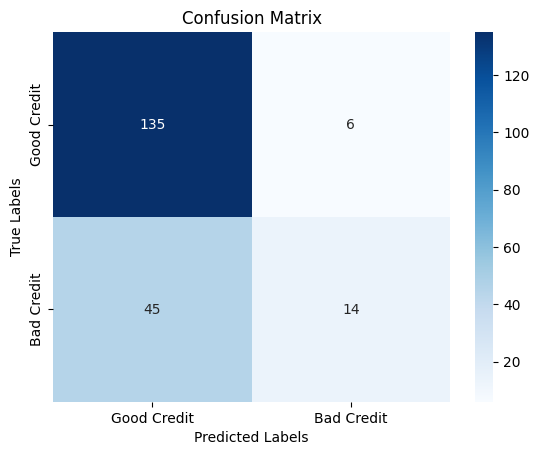

In [27]:
# Metrics
accuracy = accuracy_score(testing_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(testing_labels, predicted_labels, average='macro')
my_confusion_matrix = confusion_matrix(testing_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:")

# Confusion matrix
seaborn.heatmap(my_confusion_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Good Credit', 'Bad Credit'],
            yticklabels=['Good Credit', 'Bad Credit'])


plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")


plt.show()